# Colombian Elections Tweet Sentiment and Text Generation

### Authors: Natasha Savic, Javier Galvis Moreno

### About this Project
This notebook introduces two approaches to capture tweet sentiments during meaningful events. In this particular case, we will focus on the Colombian election day 2018 and divided our analysis in two parts:

- The first approach uses **Machine Learning techniques to classify tweets according to their sentiment** as either positive or, negative. The model has been trained on Spanish datasets where labels were available. This has been done because for the scraped tweets no labels were available.

- The second approach introduces **text generation using Deep LSTM Neural Networks**. The same tweets have been fed into the network in order to output a text which summarises/captures context around keywords that are contained in the tweets. While such approach does not provide a clear classification of tweets, we were able to capture the general sentiment towards a certain topic/keyword. In order to improve this prototype, we encourage the use of bigger datasets.



### Why and where is the application needed?

We believe there is a growing need for media companies to capture and share in real-time the online sentiment regarding specific topics.<br>

For this particular project we are focusing on the political arena given that Colombia is currently going through its presidential elections and the main use case that we are picturing is the live coverage of online sentiment during presidential debates. We hope that a tool like this one (and after solving for other kind of problems, such as social networks bot-armies), will allow for more transparency and a better representation of the audience opinions. <br>

**Labeled Sentiment classification**
* Is the current audience's attitude positive or negative?

**Text Generation**
* Would provide a feel of what the audience associates to a certain keyword

## Is there any other approach / System trying to solve this use case?

While we specifically focussed on Colombian election day tweets, this project could be applied to any topic which is subject to large-audience news broadcasting such as live feed of reality shows, royal weddings, world cups or other meaningful events. <br>

On the technical side, another approach an probably our next step would be to implement over Spark to handle the live-feed of Tweets.

## Code

In [90]:
#import warnings
#warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

#NLTK
import nltk
from nltk import word_tokenize, WordPunctTokenizer, regexp_tokenize
from nltk import word_tokenize, WordPunctTokenizer, regexp_tokenize

#Plotting 
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

#Keras
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding

# Train Data

Check this http://www.sepln.org/workshops/tass/2017/

In [3]:
import xml.etree.ElementTree as ET
tree = ET.parse('TASS_data/general_corpus_2012/general-train-tagged-3l.xml')
root = tree.getroot()

In [4]:
train_set = pd.DataFrame({'tweet_id':[],'tweetText':[],'polarity_value':[],'polarity_type':[],'topic':[]})
row=0
for tweet in root:
    tweet_id = 'ID:'+tweet.find('tweetid').text
    #user = tweet.find('user').text
    tweetText = tweet.find('content').text
    lang = tweet.find('lang').text
    polarity_value = tweet.find('sentiments').find('polarity').find('value').text
    polarity_type = tweet.find('sentiments').find('polarity').find('type').text
    topic = tweet.find('topics').find('topic').text
    
    if lang == 'es':
        train_set.loc[row] = [tweet_id,tweetText,polarity_value,polarity_type,topic]
        row+=1

In [5]:
train_set['set'] = 'train'

In [6]:
train_set.head(10)

,tweet_id,tweetText,polarity_value,polarity_type,topic,set
0,ID:142389495503925248,"Salgo de #VeoTV , que día más largoooooo...",NONE,AGREEMENT,otros,train
1,ID:142389933619945473,@PauladeLasHeras No te libraras de ayudar me/n...,NEU,DISAGREEMENT,otros,train
2,ID:142391947707940864,@marodriguezb Gracias MAR,P,AGREEMENT,otros,train
3,ID:142416095012339712,"Off pensando en el regalito Sinde, la que se v...",N,AGREEMENT,política,train
4,ID:142422495721562112,Conozco a alguien q es adicto al drama! Ja ja ...,P,AGREEMENT,otros,train
5,ID:142424715175280640,"RT @FabHddzC: Si amas a alguien, déjalo libre....",NONE,AGREEMENT,música,train
6,ID:142483342040907776,Toca @crackoviadeTV3 . Grabación dl especial N...,P,AGREEMENT,entretenimiento,train
7,ID:142493511634259968,Hoy asisitiré en Madrid a un seminario sobre l...,NONE,AGREEMENT,política,train
8,ID:142494476051562496,Buen día todos! Lo primero mandar un abrazo gr...,P,AGREEMENT,otros,train
9,ID:142496796416016384,Desde el escaño. Todo listo para empezar #endi...,P,AGREEMENT,política,train


In [7]:
#Rename columns
train_set.columns = ['tweet_id', 'tweetText', 'polarity_value', 'polarity_type', 'topic','set']

In [8]:
train_set.head(4)

,tweet_id,tweetText,polarity_value,polarity_type,topic,set
0,ID:142389495503925248,"Salgo de #VeoTV , que día más largoooooo...",NONE,AGREEMENT,otros,train
1,ID:142389933619945473,@PauladeLasHeras No te libraras de ayudar me/n...,NEU,DISAGREEMENT,otros,train
2,ID:142391947707940864,@marodriguezb Gracias MAR,P,AGREEMENT,otros,train
3,ID:142416095012339712,"Off pensando en el regalito Sinde, la que se v...",N,AGREEMENT,política,train


In [9]:
train_set.tweetText[0]

'Salgo de #VeoTV , que día más largoooooo...'

In [10]:
train_set.topic.value_counts()

política           2715
otros              1620
entretenimiento    1209
economía            525
música              412
fútbol              225
cine                183
tecnología          144
deportes            101
literatura           84
Name: topic, dtype: int64

In [11]:
train_set.polarity_value.value_counts()

P       2884
N       2182
NONE    1482
NEU      670
Name: polarity_value, dtype: int64

Let's keep only the positive and negative tweets

In [12]:
train_set = train_set.loc[(train_set.polarity_value == 'P') | (train_set.polarity_value == 'N') ]

# Colombian Tweets

In [13]:
#tweets = pd.read_csv('tweets_mentioning_candidates.csv')
tweets = pd.read_csv('tweets_mentioning_candidates.csv')
tweets['set'] = 'test'
tweets['polarity_value'] = np.NaN

In [14]:
tweets.shape

(30000, 18)

# Processing Tweets

Merge both datasets for pre-processing.

In [15]:
processed_tweets= pd.concat([pd.DataFrame({'tweetID':tweets.tweetID, 'tweetText':tweets.tweetText,'polarity_value':tweets.polarity_value, 'set':tweets.set}), 
                             pd.DataFrame({'tweetID':train_set.tweet_id, 'tweetText':train_set.tweetText, 'polarity_value':train_set.polarity_value,'set':train_set.set})], ignore_index=True)
processed_tweets['processed_tweet'] = processed_tweets.tweetText
processed_tweets.sample(4)

,tweetID,tweetText,polarity_value,set,processed_tweet
16011,ID:1008494760296894464,"Espero que, con @IvanDuque todo vaya muy bien ...",NaN,test,"Espero que, con @IvanDuque todo vaya muy bien ..."
27792,ID:1008488345595465729,"@PinoCalad @IvanDuque @PublimetroCol Adelante,...",NaN,test,"@PinoCalad @IvanDuque @PublimetroCol Adelante,..."
15200,ID:1008495229442383873,@RevistaSemana @petrogustavo @IvanDuque @HOLLM...,NaN,test,@RevistaSemana @petrogustavo @IvanDuque @HOLLM...
11177,ID:1008497564386254850,"@IvanDuque @JuanManSantos Presidente electo, f...",NaN,test,"@IvanDuque @JuanManSantos Presidente electo, f..."


### Hashtags

In [16]:
import re
hash_regex = re.compile(r"#(\w+)")
hstgs = [] # To store the hashtags so we can exclude them from some parts of the analysis
def hash_repl(match):
    _ = '__HASH_'+match.group(1).upper()
    hstgs.append(_)
    return _

### User names

In [17]:
user_regex = re.compile(r"@(\w+)")
usr_names = [] # To store the user names so we can exclude them from some parts of the analysis
def user_repl(match):
    _ = '__user_'+match.group(1).upper()
    usr_names.append(_)
    return _

### URLs

In [18]:
url_regex = re.compile(r"(http|https|ftp)://[a-zA-Z0-9\./]+")
def url_repl(match):
    return '__URL_'

In [19]:
# processed_tweets['processed_tweet'] = [re.sub(url_regex, url_repl, str(s)) for s in processed_tweets.processed_tweet]

### Reppppppppetitions

In [19]:
# Repeating words like hurrrryyyyyy
rpt_regex = re.compile(r"(.)\1{1,}", re.IGNORECASE);
def rpt_repl(match):
    return match.group(1)+match.group(1)

In [20]:
# Test
re.sub(rpt_regex, rpt_repl, "Reppppeated characters in wordsssssssss" )

'Reppeated characters in wordss'

### Punctuation

In [21]:
# Spliting by word boundaries
word_bound_regex = re.compile(r"\W+")

# Punctuations
punctuations = \
	[	#('',		['.', ] )	,\
		#('',		[',', ] )	,\
		#('',		['\'', '\"', ] )	,\
		('__PUNC_EXCL',		['!', '¡', ] )	,\
		('__PUNC_QUES',		['?', '¿', ] )	,\
		('__PUNC_ELLP',		['...', '…', ] )	,\
	]

#For punctuation replacement
def punctuations_repl(match):
	text = match.group(0)
	repl = []
	for (key, parr) in punctuations :
		for punc in parr :
			if punc in text:
				repl.append(key)
	if( len(repl)>0 ) :
		return ' '+' '.join(repl)+' '
	else :
		return ' '

In [23]:
# processed_tweets['processed_tweet'] = [re.sub(word_bound_regex, punctuations_repl, str(s)) for s in processed_tweets.processed_tweet]

### Stemming
As there is no spanish language for PorterStemmer, go with snowball!

In [22]:
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('spanish')

In [23]:
# Test
text = processed_tweets.processed_tweet[55]
print(text)
text = [word if(word[0:2]=='__') else word.lower() for word in text.split() if ((len(word) >= 3) and (word not in usr_names))]
text = [stemmer.stem(w) for w in text]                
text = " ".join(text)
print('------------------')
print(text)

@IvanDuque Presidente, desde ya bendiciones ! Me gustaría trabajar al lado suyo. Bendiciones y sabiduría !
------------------
@ivanduqu presidente, desd bendicion gust trabaj lad suyo. bendicion sabidur


In [24]:
def sb_stem(text, only_first=0):
    text = [word if(word[0:2]=='__') else word.lower() for word in text.split() if ((len(word) >= 3) or (word in ['no','si', 'sí', 'ni']))] #   If we are doing negation analysis, maybe is a better idea to keep the small words (like 'no')
    text = [stemmer.stem(w) if w[0:2]!='__' else w for w in text ]
    
    return(text)

In [26]:
# processed_tweets['processed_tweet'] = processed_tweets.processed_tweet.apply(sb_stem)

In [25]:
def processAll(text):
    text = re.sub( hash_regex, hash_repl, text )
    text = re.sub( user_regex, user_repl, text)
    text = re.sub( url_regex, url_repl, text )
    
    text = text.replace('\'','')
    
    text = re.sub( word_bound_regex , punctuations_repl, text )
    text = re.sub( rpt_regex, rpt_repl, text )
    
    text = sb_stem(text)    
    return text

### Process tweets

Now we can process the tweets with the recently created functions

In [27]:
processed_tweets['processed_tweet'] = processed_tweets.tweetText.apply(processAll)

In [28]:
#check
processed_tweets.sample(4)

,tweetID,tweetText,polarity_value,set,processed_tweet
20506,ID:1008492314493358080,@petrogustavo @miguelhotero No vas a see gobie...,NaN,test,"[__user_PETROGUSTAVO, __user_MIGUELHOTERO, vas..."
27855,ID:1008488309260259328,@Caroriveroa @petrogustavo Sueño con decirle p...,NaN,test,"[__user_CARORIVEROA, __user_PETROGUSTAVO, sueñ..."
12725,ID:1008496705371820033,@giovannacortesc @VickyDavilaH @petrogustavo @...,NaN,test,"[__user_GIOVANNACORTESC, __user_VICKYDAVILAH, ..."
2985,ID:1008502722113556480,@IvanDuque usted no es mi presidente #duqueno...,NaN,test,"[__user_IVANDUQUE, usted, no, president, __HAS..."


## Feature Creation

### Emoticons

Emojis on the Spanish tweets, unlike on the Colombian ones, are stored as combinations of characters, such as :) . We will try to put them all on the same page for the feature engineering. That is, we will translate them to their Unicode value. Let's begin with the spanish ones.

In [29]:
# Emoticons
emoticons = \
	[	# For __EMOT_SMILEY
        (' __emoji: U+1F601',	[':-)', ':)', '(:', '(-:', ] )	,\
        # for __EMOT_LAUGH
		(' __emoji: U+1F923',		[':-D', ':D', 'X-D', 'XD', 'xD', ] )	,\
        # For __EMOT_LOVE
		(' __emoji: U+2764',		['<3', ':\*', ] )	,\
        # For __EMOT_WINK
		('__emoji: U+1F609',		[';-)', ';)', ';-D', ';D', '(;', '(-;', ] )	,\
        # For __EMOT_FROWN
		(' __emoji: U+2639',		[':-(', ':(', '(:', '(-:', ] )	,\
        # For __EMOT_CRY
		(' __emoji: U+1F622',		[':,(', ':\'(', ':"(', ':(('] )	,\
	]
    
def escape_paren(arr):
	return [text.replace(')', '[)}\]]').replace('(', '[({\[]') for text in arr]

def regex_union(arr):
	return '(' + '|'.join( arr ) + ')'

emoticons_regex = [ (repl, re.compile(regex_union(escape_paren(regx))) ) for (repl, regx) in emoticons ]

In [30]:
# Test
text = "This is a text with one emoticon :) and another :("
for (repl, regx) in emoticons_regex :
    text = re.sub(regx, ' '+repl+' ', text)
    
print(text)

This is a text with one emoticon   __emoji: U+1F601  and another   __emoji: U+2639 


Now we can do something similar for the Colombian tweets, we will translate them to their respective  unicode values:

In [31]:
# data scraped from http://www.unicode.org/emoji/charts/full-emoji-list.html
emojis_db=pd.read_csv('emojis_db_csv.csv')
emojis_db.head()

,emoji_category,number,code,CLDR_Short_Name
0,face-positive,1,U+1F600,grinning face
1,face-positive,2,U+1F601,beaming face with smiling eyes
2,face-positive,3,U+1F602,face with tears of joy
3,face-positive,4,U+1F923,rolling on the floor laughing
4,face-positive,5,U+1F603,grinning face with big eyes


In [32]:
emojis_db.emoji_category.unique()

array(['face-positive', 'face-neutral', 'face-negative', 'face-sick',
       'face-role', 'face-fantasy', 'cat-face', 'monkey-face', 'person',
       'person-role', 'person-fantasy', 'person-gesture',
       'person-activity', 'person-sport', 'family', 'body', 'hair-style',
       'emotion', 'clothing', 'animal-mammal', 'animal-bird',
       'animal-amphibian', 'animal-reptile', 'animal-marine',
       'animal-bug', 'plant-flower', 'plant-other', 'food-fruit',
       'food-vegetable', 'food-prepared', 'food-asian', 'food-sweet',
       'drink', 'dishware', 'place-map', 'place-geographic',
       'place-building', 'place-religious', 'place-other',
       'transport-ground', 'transport-water', 'transport-air', 'hotel',
       'time', 'sky & weather', 'event', 'award-medal', 'sport', 'game',
       'arts & crafts', 'sound', 'music', 'musical-instrument', 'phone',
       'computer', 'light & video', 'book-paper', 'money', 'mail',
       'writing', 'office', 'lock', 'tool', 'science', 'medi

Emojis present on tweets on the colombian dataset are encoded as the actual emoji image, the following function will extract the unicode from each emoji so we can use it as a feature.

In [33]:
def emojis_unicode(tweet):
    ''' Extracts the emojis on the tweet on Unicode format, also tries to match those in regular format, such as ";)" '''
    for (repl, regx) in emoticons_regex :
        tweet = re.sub(regx, ' '+repl+' ', tweet)
#     print(tweet)

    tweet_unicode = str(tweet.encode('unicode-escape'))
    tweet_unicode = tweet_unicode.replace('\\\\U000',' __emoji: U+')
#     print(tweet_unicode)
    
    emoji_list = []
#     print(tweet)
    for emoji in range(tweet_unicode.count(' __emoji: ')):
        em = tweet_unicode.split('__emoji: ')[emoji+1].split()[0]
        em = em[:7] # the len of the emoji in unicode is between 6 and 7
        emoji_list.append(em.upper())
    return emoji_list

In [34]:
# Test
text = "This is a text with one emoticon :) and another :( and some others: 😡 🤣😂"
emojis_unicode(text)

['U+1F601', 'U+2639', 'U+1F621', 'U+1F923', 'U+1F602']

In [37]:
# processed_tweets['emojis_unicode'] = processed_tweets.tweetText.apply(emojis_unicode) # np.vectorize(emojis_unicode)(processed_tweets['tweetText'])

Now we can get the category of the extracted emojis

In [35]:
def emoji_category(emojis):
    categories = []
    for i in range(len(emojis)):
        # print(emojis[i])
        try:
            categories.append(emojis_db.loc[emojis_db.code == emojis[i]].emoji_category.values[0])
        except:
            try:
                _ = emojis[i].split('+')[1] + '+'
                categories.append(emojis_db[emojis_db.code.str.contains(_)].emoji_category.values[0])
            except:
                categories.append('other')
    if len(categories) < 1:
        categories.append('no_emojis')
    return categories

emoji_category(emojis_unicode(text))

['face-positive',
 'face-negative',
 'face-negative',
 'face-positive',
 'face-positive']

In [39]:
# processed_tweets['emojis_categories'] = processed_tweets.emojis_unicode.apply(emoji_category)

In [40]:
# processed_tweets.head()

### N-grams

In [36]:
# Unigrams
unigrams_fd = nltk.FreqDist()
# unigrams_fd.update(text)
# unigrams_fd

# Bigrams
# words_bi  = [ ','.join(map(str,bg)) for bg in nltk.bigrams(text) ]
bi_grams_fd = nltk.FreqDist()
# bi_grams_fd.update( words_bi )
# bi_grams_fd

# Trigrams
# words_tri  = [ ','.join(map(str,tg)) for tg in nltk.trigrams(text) ]
tri_grams_fd = nltk.FreqDist()
# tri_grams_fd.update( words_tri )
# tri_grams_fd

In [37]:
# Wrapper function that encloses all the n-grams procedures
def get_word_features(words):
    bag = {}
    words_uni = [ 'has(%s)'% ug for ug in words ]
    words_bi  = [ 'has(%s)'% ','.join(map(str,bg)) for bg in nltk.bigrams(words) ]
    words_tri = [ 'has(%s)'% ','.join(map(str,tg)) for tg in nltk.trigrams(words) ]
    
    for f in words_uni+words_bi+words_tri:
        bag[f] = 1

    return bag

### Negation

In [38]:
sb_stem('nunca no nada ningún ninguno ninguna tampoco')

['nunc', 'no', 'nad', 'ningun', 'ningun', 'ningun', 'tampoc']

In [39]:
negtn_regex = re.compile( r"""(?:
    ^(?:nunca|no|nada|ningún|ninguno|ninguna|tampoco|
        nunc|nad|ningun|tampoc
    )$
)
|
n't
""", re.X)

def get_negation_features(words):
    INF = 0.0
    negtn = [ bool(negtn_regex.search(w)) for w in words ]

    left = [0.0] * len(words)
    prev = 0.0
    for i in range(0,len(words)):
        if( negtn[i] ):
            prev = 1.0
        left[i] = prev
        prev = max( 0.0, prev-0.1)

    right = [0.0] * len(words)
    prev = 0.0
    for i in reversed(range(0,len(words))):
        if( negtn[i] ):
            prev = 1.0
        right[i] = prev
        prev = max( 0.0, prev-0.1)

    return dict( zip(
                    ['neg_l('+w+')' for w in  words] + ['neg_r('+w+')' for w in  words],
                    left + right ) )

In [40]:
# Test
text = ["Este","tweet", "no", "es", "positivo"]
get_negation_features(text)

{'neg_l(Este)': 0.0,
 'neg_l(tweet)': 0.0,
 'neg_l(no)': 1.0,
 'neg_l(es)': 0.9,
 'neg_l(positivo)': 0.8,
 'neg_r(Este)': 0.8,
 'neg_r(tweet)': 0.9,
 'neg_r(no)': 1.0,
 'neg_r(es)': 0.0,
 'neg_r(positivo)': 0.0}

### Polarity

We tried using the spanish sentiment lexicon from http://www.opener-project.eu/ but it didn't improve the results on any of the algorithms. Maybe due to the fact that spanish from Spain is different from the spanish spoken in Colombia.

In [41]:
opener_lexicon = pd.read_csv('https://raw.githubusercontent.com/opener-project/public-sentiment-lexicons/master/propagation_lexicons/es/es.lemma.sy.an.hypo.rels.maxdepth5.seed500.maj.gold.csv', sep=';', header=None)
opener_lexicon.columns = ['x','pos', 'polarity', 'xx','word','xxx']
opener_lexicon.head()

,x,pos,polarity,xx,word,xxx
0,unknown,n,positive,1.0,felicitación,1
1,unknown,a,negative,1.0,inconsciente,1
2,unknown,n,neutral,1.0,soporte,1
3,unknown,n,neutral,1.0,proceso_matemático,1
4,unknown,v,positive,1.0,manifestar,1


As the meaning of columns 4 and 6 is not known by us at the moment, they won't be included on the analysis.

In [42]:
def get_sent(polarity):
    if polarity == 'neutral':
        return 0
    if polarity == 'negative':
        return -1
    if polarity == 'positive':
        return 1
opener_lexicon['sentiment'] = opener_lexicon.polarity.apply(get_sent)

In [43]:
opener_lexicon['stmd_word'] = opener_lexicon['word'].apply(sb_stem)
opener_lexicon['stmd_word'] = opener_lexicon.stmd_word.apply(lambda x: str(x).replace('[','').replace(']','').replace("'",''))
opener_lexicon = opener_lexicon[['word','stmd_word','sentiment']]
opener_lexicon = opener_lexicon.loc[opener_lexicon.sentiment != 0]
opener_lexicon = opener_lexicon.drop_duplicates()
opener_lexicon.sample(4)

,word,stmd_word,sentiment
1754,disminuir,disminu,-1.0
6295,filtrar,filtr,1.0
1949,sorprendente,sorprendent,1.0
5820,adorno,adorn,1.0


In [49]:
def get_polarity_features(text):
    pol = {}
    text = sb_stem(text)
    for word in text:
        try:
            pol["sent("+word+")"] = opener_lexicon.loc[opener_lexicon.stmd_word == word].sentiment.values[0]
        except:
            continue
            
    return pol

_ = processed_tweets.tweetText[1503]
print('Tweet ',_)
print('Would have the following words and sentiments associated:')
print(get_polarity_features(_))

Tweet  @OIZuluaga @IvanDuque Lo que se construye con la corrupción solo es del beneficio de unos pocos (Odebrecht)
Would have the following words and sentiments associated:
{'sent(sol)': 1.0, 'sent(benefici)': 1.0}


### Apply Features

In [44]:
# Wrapper function for the extraction of features
def extract_features(text):
    global usr_names, hstgs
    features = {}
    words = text
    words = processAll(text)

    word_features = get_word_features(words)
    features.update( word_features )

    negation_features = get_negation_features(words)
    features.update( negation_features )
    
    # Sentiment features are not included on the final deliverabe as did not improve results
#     sentiment_features = get_polarity_features(text)
#     features.update(sentiment_features )
    
    emoji_features = emoji_category(emojis_unicode(text))
    emoji_features_dic = dict( zip(['emoji_('+w+')' for w in  emoji_features], emoji_features))
    features.update( emoji_features_dic )
    
    usr_names = list(set(usr_names))
    hstgs = list(set(hstgs))
    return features

In [45]:
processed_tweets['processed_tweet_features'] = processed_tweets.tweetText.apply(extract_features)

In [46]:
processed_tweets.processed_tweet_features[150]

{'has(__user_CUERVOJI)': 1,
 'has(__user_DCORONELL)': 1,
 'has(__user_PETROGUSTAVO)': 1,
 'has(desgraci)': 1,
 'has(compart)': 1,
 'has(esa)': 1,
 'has(opinion)': 1,
 'has(__user_CUERVOJI,__user_DCORONELL)': 1,
 'has(__user_DCORONELL,__user_PETROGUSTAVO)': 1,
 'has(__user_PETROGUSTAVO,desgraci)': 1,
 'has(desgraci,compart)': 1,
 'has(compart,esa)': 1,
 'has(esa,opinion)': 1,
 'has(__user_CUERVOJI,__user_DCORONELL,__user_PETROGUSTAVO)': 1,
 'has(__user_DCORONELL,__user_PETROGUSTAVO,desgraci)': 1,
 'has(__user_PETROGUSTAVO,desgraci,compart)': 1,
 'has(desgraci,compart,esa)': 1,
 'has(compart,esa,opinion)': 1,
 'neg_l(__user_CUERVOJI)': 0.0,
 'neg_l(__user_DCORONELL)': 0.0,
 'neg_l(__user_PETROGUSTAVO)': 0.0,
 'neg_l(desgraci)': 0.0,
 'neg_l(compart)': 0.0,
 'neg_l(esa)': 0.0,
 'neg_l(opinion)': 0.0,
 'neg_r(__user_CUERVOJI)': 0.0,
 'neg_r(__user_DCORONELL)': 0.0,
 'neg_r(__user_PETROGUSTAVO)': 0.0,
 'neg_r(desgraci)': 0.0,
 'neg_r(compart)': 0.0,
 'neg_r(esa)': 0.0,
 'neg_r(opinion)': 0.

In [47]:
processed_tweets.sample(4)

,tweetID,tweetText,polarity_value,set,processed_tweet,processed_tweet_features
7411,ID:1008499782762016774,#Domingo Gracias Dios por permitirme estar cer...,NaN,test,"[__HASH_DOMINGO, graci, dios, por, permit, est...","{'has(__HASH_DOMINGO)': 1, 'has(graci)': 1, 'h..."
3310,ID:1008502527325868032,@IvanDuque @JuanManSantos Con usted no puede h...,NaN,test,"[__user_IVANDUQUE, __user_JUANMANSANTOS, con, ...","{'has(__user_IVANDUQUE)': 1, 'has(__user_JUANM..."
3850,ID:1008502216569876480,@kevincaracol @petrogustavo Digan que no les g...,NaN,test,"[__user_KEVINCARACOL, __user_PETROGUSTAVO, dig...","{'has(__user_KEVINCARACOL)': 1, 'has(__user_PE..."
1695,ID:1008503445303758848,Que lindo el discurso de @IvanDuque ! El mismo...,NaN,test,"[que, lind, discurs, __user_IVANDUQUE, __PUNC_...","{'has(que)': 1, 'has(lind)': 1, 'has(discurs)'..."


# Part 1: Classification - Sentiment Analysis

In [48]:
train_ = processed_tweets.loc[processed_tweets.set == 'train']
test_ = processed_tweets.loc[processed_tweets.set == 'test']

In [49]:
test_.head()

,tweetID,tweetText,polarity_value,set,processed_tweet,processed_tweet_features
0,ID:1008504539916455936,Lo mejor del discurso de @IvanDuque es cuando ...,NaN,test,"[mejor, del, discurs, __user_IVANDUQUE, cuand,...","{'has(mejor)': 1, 'has(del)': 1, 'has(discurs)..."
1,ID:1008504538981191680,@manuelrosalesg @IvanDuque @mluciaramirez Los ...,NaN,test,"[__user_MANUELROSALESG, __user_IVANDUQUE, __us...","{'has(__user_MANUELROSALESG)': 1, 'has(__user_..."
2,ID:1008504538242977792,@gloserna @fransupelano @icolombianoo @AlvaroU...,NaN,test,"[__user_GLOSERNA, __user_FRANSUPELANO, __user_...","{'has(__user_GLOSERNA)': 1, 'has(__user_FRANSU..."
3,ID:1008504536208683013,@_El_Patriota @petrogustavo @JSantrich_FARC Pa...,NaN,test,"[__user__EL_PATRIOTA, __user_PETROGUSTAVO, __u...","{'has(__user__EL_PATRIOTA)': 1, 'has(__user_PE..."
4,ID:1008504534371635201,Que diferencia de discursos! Gracias @IvanDuque,NaN,test,"[que, diferent, discurs, __PUNC_EXCL, graci, _...","{'has(que)': 1, 'has(diferent)': 1, 'has(discu..."


In [50]:
train_size = int(train_.shape[0]*0.8)
sentiment_train_tweets = [(tweet, sentiment) for tweet, sentiment in train_[['tweetText', 'polarity_value']].values[:train_size]]
sentiment_train_tweets_full = [(tweet, sentiment) for tweet, sentiment in train_[['tweetText', 'polarity_value']].values]
sentiment_validation_tweets = [(tweet, sentiment) for tweet, sentiment in train_[['tweetText', 'polarity_value']].values[train_size:]]
sentiment_test_tweets  = [(tweet, sentiment) for tweet, sentiment in test_[['tweetText', 'polarity_value']].values]

## Data Preparation

In [51]:
# Apply the data processing and cleaning extraction methodologies
v_train = nltk.classify.apply_features(extract_features,sentiment_train_tweets)
v_train_full = nltk.classify.apply_features(extract_features,sentiment_train_tweets_full)
v_validation = nltk.classify.apply_features(extract_features,sentiment_validation_tweets)
v_test  = nltk.classify.apply_features(extract_features,sentiment_test_tweets)

In [52]:
print ("For the tweet = ", train_.tweetText.values[10] )
print (" ")
print ("The following features has been created:")
print (" ")
print (v_train[0][0])

For the tweet =  “@adri_22_22: #programascambiados es TT gracias a @Carlos_Latre” GRACIAS POR EL BUEN RATO AMIGOS!!;)
 
The following features has been created:
 
{'has(__user_MARODRIGUEZB)': 1, 'has(graci)': 1, 'has(mar)': 1, 'has(__user_MARODRIGUEZB,graci)': 1, 'has(graci,mar)': 1, 'has(__user_MARODRIGUEZB,graci,mar)': 1, 'neg_l(__user_MARODRIGUEZB)': 0.0, 'neg_l(graci)': 0.0, 'neg_l(mar)': 0.0, 'neg_r(__user_MARODRIGUEZB)': 0.0, 'neg_r(graci)': 0.0, 'neg_r(mar)': 0.0, 'emoji_(no_emojis)': 'no_emojis'}


## Naive Bayes

In [53]:
nb_classifier = nltk.classify.NaiveBayesClassifier
nb_class = nb_classifier.train(v_train)
print ("Accuracy of the model = ", nltk.classify.accuracy(nb_class, v_validation))

Accuracy of the model =  0.8047337278106509


Accuracy looks good enough, we can try now to train on the whole set and run on the Colombian tweets

In [54]:
nb_class = nb_classifier.train(v_train_full) 
test_predict = [nb_class.classify(t) for (t,s) in v_test]

In [55]:
NB_results = pd.DataFrame({'tweet': sentiment_test_tweets,'sentiment':test_predict})

There is no way to measure test accuracy as the colombian tweets are not labeled. Clearly, as our production set is a different kind of Spanish (Colombia Vs. Spain on the test set), classification score shouldn't be expected to be as high on this proof of concept, but here is a random sample for each label:

#### Positive Tweets:

In [56]:
positives = NB_results.loc[NB_results.sentiment == 'P']
# Print a sample of Tweets
sample_size = 10
for tweet in positives.tweet.sample(sample_size):
    print(tweet)

('Hoy gana la democracia de mi pais, la guerra politica en las redes sociales ha finalizado, felicito a @IvanDuque por la victoria en sus manos esta el futuro de Colombia y esperamos que sus promesas se hagan realidad por un futuro mejor. https://t.co/c8JsvX8spP', nan)
('@elespectador @petrogustavo Duque 60,3% !!! En bucaramanga 🤦\u200d♂️🤦\u200d♂️', nan)
('@fuenteseliz @petrogustavo que será lo que quiere el Petro? Tibi y baranda! Más naaaa.....!', nan)
('@DCoronell @petrogustavo Hoy lo dejo de seguir.', nan)
('@ELTIEMPO @petrogustavo Me encanta el “hubiéramos”', nan)
('@CaracolRadio @petrogustavo Para ser exactos la perdida no fue para la campaña de Gustavo Petro fue para una Colombia ignorante que apoya a la corrupcion de @IvanDuque que simplemente es una marioneta de la dictadura que se viene con @AlvaroUribeVel  ¡Gracias por su imparcialidad @CaracolRadio!', nan)
('@petrogustavo Estás prendido dice mi esposo mexicano que dirán todos los colombianos', nan)
('@Almagro_OEA2015 @IvanDu

#### Negative Tweets:

In [57]:
negatives = NB_results.loc[NB_results.sentiment == 'N']
# Print a sample of Tweets
sample_size = 10
for tweet in negatives.tweet.sample(sample_size):
    print(tweet)

('Tras su derrota, @petrogustavo reconoce el triunfo de @IvanDuque en su discurso y anuncia que hará oposición al próximo gobierno.\n\n#ColombiaDecide2018 🇨🇴', nan)
('ENORME este discurso de @petrogustavo', nan)
('8 millones de colombianos que vamos a cuidar el agua, no al fracking @petrogustavo es un compromiso. gracias por abrirle los ojos al país. #IvanDuqueNoEsMiPresidente #GraciasPetro', nan)
('@petrogustavo Felicitaciones a los colombianos por haber evitado se repitiera la misma tragedia de Venezuela. Comunismo es hambre, miseria y atraso.', nan)
('Oigan y el hijo de @petrogustavo que debía la platica y dijo que pagaba mañana será que se va a hacer el “no heterosexual” ?? Feo eso!! #ColombiaElige2018', nan)
('Estoy destrozado pero este trino es de lo mejor que he leído! Perdieron nuestros hermanos los animales, nuestros recursos naturales, las comunidades ancestrales, pero @petrogustavo fue tremendo guerrero. Miren porqué @piedrahitangela @Pauliina_Mejia https://t.co/DxEr4TZsSM',

### Results of Colombian Election Tweet Sentiment

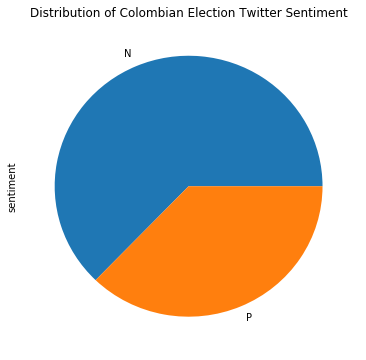

In [58]:
NB_results['sentiment'].value_counts().plot(kind='pie', title="Distribution of Colombian Election Twitter Sentiment", figsize=(6,6))

In [59]:
nb_class.show_most_informative_features(10)

Most Informative Features
            neg_r(felic) = 0.0                 P : N      =     30.5 : 1.0
             has(encant) = 1                   P : N      =     27.5 : 1.0
          has(graci,por) = 1                   P : N      =     27.5 : 1.0
           neg_r(encant) = 0.0                 P : N      =     27.5 : 1.0
           neg_l(encant) = 0.0                 P : N      =     26.5 : 1.0
           has(muy,buen) = 1                   P : N      =     23.5 : 1.0
          has(__HASH_FF) = 1                   P : N      =     20.9 : 1.0
        neg_l(__HASH_FF) = 0.0                 P : N      =     20.9 : 1.0
   emoji_(face-positive) = 'face-positive'      P : N      =     20.7 : 1.0
  has(graci,__PUNC_EXCL) = 1                   P : N      =     20.4 : 1.0


### Max Entropy

We tried with Max-entropy classifier, however better results were achieved with Naive Bayes.

In [66]:
#max_ent_classifier_0 = nltk.classify.MaxentClassifier
#max_ent_class_0 = max_ent_classifier_0.train(v_train, algorithm='GIS', max_iter=25)

In [67]:
#print ("Accuracy of the model = ", nltk.classify.accuracy(max_ent_class_0, v_validation))

# Part 2 : Tweet Text Generation 

### Preprocess Specific Column for Training

In [60]:
#re-load the data
df = pd.read_csv('tweets_mentioning_candidates.csv')

In [61]:
df.head()

,tweetID,tweetText,urls,tweetRetweetCt,tweetFavoriteCt,tweetSource,tweetCreated,userID,userScreen,userName,userCreateDt,userDesc,userFollowerCt,userFriendsCt,userLocation,userTimezone
0,ID:1008504539916455936,Lo mejor del discurso de @IvanDuque es cuando ...,[],0,0,Twitter Web Client,2018-06-18 00:19:54,ID:533450497,Will_Perz,William PC,2012-03-22 20:05:30,NaN,29,234,NaN,NaN
1,ID:1008504538981191680,@manuelrosalesg @IvanDuque @mluciaramirez Los ...,[],0,0,Twitter for Android,2018-06-18 00:19:53,ID:1732923980,pablovillasmil1,Pablo L Villasmil,2013-09-05 19:44:21,"Tecnico Electronico, Opositor hasta la pata",172,412,"Maracaibo, Venezuela",NaN
2,ID:1008504538242977792,@gloserna @fransupelano @icolombianoo @AlvaroU...,[],0,0,Twitter for iPhone,2018-06-18 00:19:53,ID:965163103,carevalolc87,Christian Arevalo,2012-11-22 23:35:40,Empieza una nueva historia... cambio de trabaj...,54,88,NaN,NaN
3,ID:1008504536208683013,@_El_Patriota @petrogustavo @JSantrich_FARC Pa...,[],0,0,Twitter for Android,2018-06-18 00:19:53,ID:952356028263354368,de_gamin,Calentao De Gamín,2018-01-14 01:45:45,NaN,26,96,NaN,NaN
4,ID:1008504534371635201,Que diferencia de discursos! Gracias @IvanDuque,[],0,0,Twitter for iPhone,2018-06-18 00:19:52,ID:187162735,camiloparadag,Camilo Parada Gómez,2010-09-05 13:01:58,Ortopedista y Traumatólogo. Especialista en Ci...,1618,633,Bogotá - Colombia,NaN


In [62]:
#Function defintion to preprocess data

#Data Cleaning
import re
def cleaning(s):
    s = str(s)
    s = s.lower()
    s = re.sub('\W,\s',' ',s)
    s = re.sub("\d+", "", s)
    s = re.sub('\s+',' ',s)
    s = re.sub('[!#$_]', '', s)
    s = re.sub('[^\\w\\.\\s\\-]+', '', s)
    s = s.replace("https","")
    s = s.replace(",","")
    s = s.replace("[\w*"," ")
    return s

#Extract the username
user_regex = re.compile(r"@(\w+)")
def user_repl(match):
	return '__user_'+match.group(1).upper()


#Replace Emojicons for one word
emoticons = \
	[	('__EMOT_SMILEY',	[':-)', ':)', '(:', '(-:', ] )	,\
		('__EMOT_LAUGH',		[':-D', ':D', 'X-D', 'XD', 'xD', ] )	,\
		('__EMOT_LOVE',		['<3', ':\*', ] )	,\
		('__EMOT_WINK',		[';-)', ';)', ';-D', ';D', '(;', '(-;', ] )	,\
		('__EMOT_FROWN',		[':-(', ':(', '(:', '(-:', ] )	,\
		('__EMOT_CRY',		[':,(', ':\'(', ':"(', ':(('] )	,\
	]
    
def escape_paren(arr):
	return [text.replace(')', '[)}\]]').replace('(', '[({\[]') for text in arr]

def regex_union(arr):
	return '(' + '|'.join( arr ) + ')'

emoticons_regex = [ (repl, re.compile(regex_union(escape_paren(regx))) ) for (repl, regx) in emoticons ]

In [63]:
#####Apply the functions - be mindful of the order

# Clean the usernames 
df['tweetText'] = [re.sub(user_regex, user_repl, str(s)) for s in df['tweetText']]

# Replace emojis
df['tweetText'] = [re.sub(user_regex, user_repl, str(s)) for s in emoticons_regex and df['tweetText']]

#Clean data - only used tweetText_for_gen column because it doesn't make sense to clean the others
df['tweetText'] = [cleaning(s) for s in df['tweetText']]

## Exploration

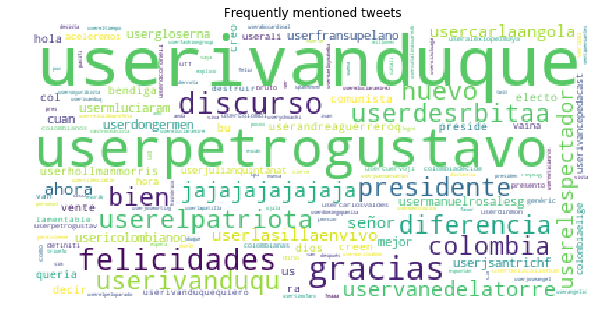

In [12]:
from nltk.corpus import stopwords
import string
#Get an idea about what words are contained
punctuation = list(string.punctuation)
stop = stopwords.words('spanish') + punctuation + ['rt', 'via']
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop,
                          max_words=150,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(df['tweetText']))
plt.imshow(wordcloud)
plt.rcParams["figure.figsize"] = (10,10)
plt.axis('off')
plt.title("Frequently mentioned tweets")
plt.show()

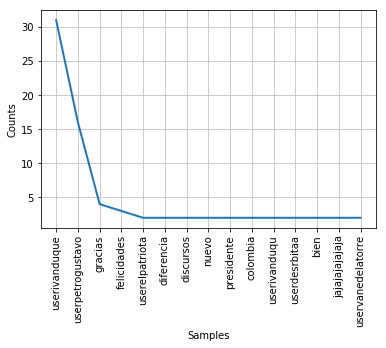

In [64]:
#Frequencies

#Get frequenies - ideally with more data since frequencies are low 
allWords = nltk.tokenize.word_tokenize(str(df['tweetText']))
allWordDist = nltk.FreqDist(w.lower() for w in allWords)

stopwords = nltk.corpus.stopwords.words('spanish')
allWordExceptStopDist = nltk.FreqDist(w.lower() for w in allWords if w not in stopwords and len(w) > 3)
allWordExceptStopDist.plot(15)

## Text Generation

In [91]:
# generate a sequence from the model
def generate_seq(model, tokenizer, seed_text, n_words):
	in_text, result = seed_text, seed_text
	# generate a fixed number of words
	for _ in range(n_words):
        
		# encode the text as integer
		encoded = tokenizer.texts_to_sequences([in_text])[0]
		encoded = array(encoded)
        
		# predict a word in the vocabulary
		yhat = model.predict_classes(encoded, verbose=0)
        
		# map predicted word index to word
		out_word = ''
		for word, index in tokenizer.word_index.items():
			if index == yhat:
				out_word = word
				break
		# append to input
		in_text, result = out_word, result + ' ' + out_word
	return result

In [92]:
# source text
data = str(df['tweetText'])

# integer encode text
tokenizer = Tokenizer()
tokenizer.fit_on_texts([data])
encoded = tokenizer.texts_to_sequences([data])[0] #return encoded words in array

In [93]:
# determine the vocabulary size
vocab_size = len(tokenizer.word_index) + 1 #dictionary with frequencies of unique words
print('Vocabulary Size: %d' % vocab_size)

# create word -> word sequences
sequences = list()
for i in range(1, len(encoded)):
	sequence = encoded[i-1:i+1]
	sequences.append(sequence)
print('Total Sequences: %d' % len(sequences))

# split into X and y elements
sequences = array(sequences)
X, y = sequences[:,0],sequences[:,1]

Vocabulary Size: 262
Total Sequences: 378


In [94]:
from keras.layers import Dropout

# one hot encode outputs
y = to_categorical(y, num_classes=vocab_size)

# define model
model = Sequential()
model.add(Embedding(vocab_size, 10, input_length=1))
model.add(Dropout(0.1, input_shape=((468, 321))))
model.add(LSTM(50))
model.add(Dropout(0.1))
model.add(Dense(vocab_size, activation='softmax'))
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 1, 10)             2620      
_________________________________________________________________
dropout_5 (Dropout)          (None, 1, 10)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                12200     
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 262)               13362     
Total params: 28,182
Trainable params: 28,182
Non-trainable params: 0
_________________________________________________________________
None


In [101]:
# compile network
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit network
model.fit(X, y, epochs=500, verbose=2)

Epoch 1/500
 - 1s - loss: 0.8400 - acc: 0.7037
Epoch 2/500
 - 0s - loss: 0.8305 - acc: 0.6825
Epoch 3/500
 - 0s - loss: 0.8329 - acc: 0.6852
Epoch 4/500
 - 0s - loss: 0.7788 - acc: 0.6931
Epoch 5/500
 - 0s - loss: 0.7975 - acc: 0.6958
Epoch 6/500
 - 0s - loss: 0.8161 - acc: 0.6799
Epoch 7/500
 - 0s - loss: 0.8003 - acc: 0.6878
Epoch 8/500
 - 0s - loss: 0.8384 - acc: 0.6534
Epoch 9/500
 - 0s - loss: 0.7829 - acc: 0.7063
Epoch 10/500
 - 0s - loss: 0.7952 - acc: 0.6931
Epoch 11/500
 - 0s - loss: 0.8329 - acc: 0.6905
Epoch 12/500
 - 0s - loss: 0.7892 - acc: 0.7196
Epoch 13/500
 - 0s - loss: 0.8206 - acc: 0.6772
Epoch 14/500
 - 0s - loss: 0.8333 - acc: 0.7011
Epoch 15/500
 - 0s - loss: 0.8035 - acc: 0.7011
Epoch 16/500
 - 0s - loss: 0.8253 - acc: 0.6878
Epoch 17/500
 - 0s - loss: 0.7829 - acc: 0.7037
Epoch 18/500
 - 0s - loss: 0.8115 - acc: 0.6905
Epoch 19/500
 - 0s - loss: 0.8244 - acc: 0.6958
Epoch 20/500
 - 0s - loss: 0.8616 - acc: 0.6667
Epoch 21/500
 - 0s - loss: 0.8192 - acc: 0.6984
E

**Accuracy is not so high but enough for our purposes!**

# Generate your text here!

**It is only able to generate the sequence for the words that are part of the vocabulary. We are currently testing in Beta! **

In [102]:
#pull some frequent words from the vocabulary
allWordExceptStopDist.most_common(10)

[('userivanduque', 31),
 ('userpetrogustavo', 16),
 ('gracias', 4),
 ('felicidades', 3),
 ('userelpatriota', 2),
 ('diferencia', 2),
 ('discursos', 2),
 ('nuevo', 2),
 ('presidente', 2),
 ('colombia', 2)]

In [119]:
string = input("What do you want to test? ")
print(generate_seq(model, tokenizer, string , 5)) #give me 5 words in a sequence

What do you want to test? diferencia
diferencia en los discursos definiti 24




While sentence does not follow correct syntactic rules it serves as an indicator what topics are sourrounding the presidential candidate Duque. It is related to the lack of jornalism for some years. A news agency could pick this hint up and investigate further. 

### Thank you for reading!